In [1]:
#HERE YOU FIND ALL THE LIBRARYS FOR THIS NOTEBOOK
%matplotlib inline
import pandas as pd
import numpy as np 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import keras
from keras.models import Sequential
from keras.layers import Dense

#this librarys are for the gpu usage
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib

Using TensorFlow backend.


In [2]:
"""
Setup multi GPU usage

Example usage:
model = Sequential()
...
multi_model = multi_gpu_model(model, gpus=num_gpu)
multi_model.fit()

About memory usage:
https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
"""

# IMPORTANT: Tells tf to not occupy a specific amount of memory
from keras.backend.tensorflow_backend import set_session  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
sess = tf.Session(config=config)  
set_session(sess)  # set this TensorFlow session as the default session for Keras.


# getting the number of GPUs 
def get_available_gpus():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos if x.device_type    == 'GPU']
num_gpu = len(get_available_gpus())
print('Amount of GPUs available: %s' % num_gpu)

Amount of GPUs available: 4


In [3]:
#SELECT THE DATA TO USE
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()

df['gasPower'] = df['gasPower']*10
df['T-1'] = df['T'].shift(1)

In [4]:
#RESAMPLE TO ONE DAY DATA
df_day = df.resample('1D').mean()
df_day = df_day.dropna()

In [5]:
df_day['hour'] = df_day.index.hour #create column containing the hour
df_day['dayofweek'] = df_day.index.dayofweek #Create column containing the day of the week

columns_to_cat = ['hour', 'dayofweek']
df_day[columns_to_cat] = df_day[columns_to_cat].astype('category') # change datetypes to category

df_day = pd.get_dummies(df_day, columns=columns_to_cat) # One hot encoding the categories

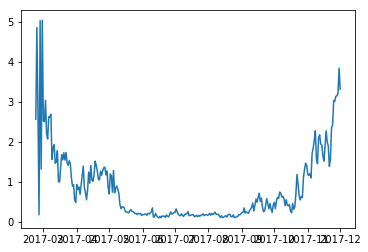

In [6]:
plt.plot(df_day.index,df_day['gasPower'])
plt.show()

In [7]:
X = df_day[['T','T-1','dayofweek_0','dayofweek_1','dayofweek_2','dayofweek_3','dayofweek_4','dayofweek_5','dayofweek_6']]
y = df_day[['gasPower']]

# labelencoder_y_1 = LabelEncoder()
# y = labelencoder_y_1.fit_transform(y)
y = np.array(y)


test_size = 0.5

split_index = int(df_day.shape[0]*test_size) # the index at which to split df into train and test

X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]
        
scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


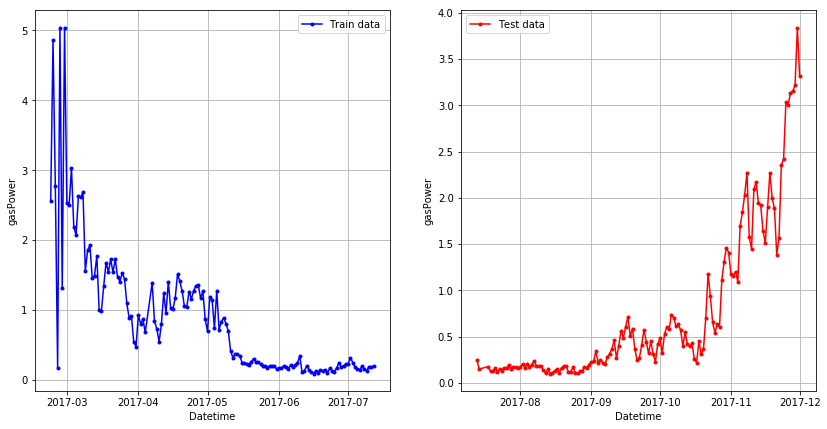

In [8]:
plt.style.use('default')
%matplotlib inline
plt.figure(figsize=(14,7))


plt.subplot(1,2,1)
plt.grid(True)
plt.plot(X_train.index,y_train,'.-',color='b',label='Train data')
plt.xlabel('Datetime')
plt.ylabel('gasPower')
plt.legend()

plt.subplot(1,2,2)
plt.grid(True)
plt.plot(X_test.index,y_test,'.-',color='r',label='Test data')
plt.xlabel('Datetime')
plt.ylabel('gasPower')
plt.legend()

plt.show()

In [9]:
len(X_train)

139

In [10]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
forecast = Sequential()

#first layer with the input data
forecast.add(Dense(output_dim =16, init = 'uniform', activation = 'relu', input_dim = 9))

#second layer 
forecast.add(Dense(output_dim = 16, init = 'uniform', activation = 'relu'))

#output layer
forecast.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=9, units=16, kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16, kernel_initializer="uniform")`
  import sys
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  # Remove the CWD from sys.path while we load stuff.


In [12]:
forecast_model = multi_gpu_model(forecast, gpus=num_gpu)

In [13]:
#compile the network
forecast_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

In [18]:
#Bach size is used to specify the number of observation after which you want to update weight
#Epoch is nothing but the total number of iterations
#We can divide the dataset of 2000 examples into batches of 500 then it will take 4 iterations to complete 1 epoch.
y_train = (y_train-min(y_train))/(max(y_train)-min(y_train))

forecast_model.fit(X_train, y_train, batch_size = 10,epochs = 100,verbose=0);

In [19]:
from sklearn.metrics import confusion_matrix

y_pred = forecast_model.predict(X_test)


In [20]:
y_pred

array([[0.04153642],
       [0.07088671],
       [0.00433161],
       [0.00462338],
       [0.01440391],
       [0.02164071],
       [0.01094908],
       [0.03177376],
       [0.03331186],
       [0.01952644],
       [0.01857069],
       [0.02173006],
       [0.03090387],
       [0.01882965],
       [0.01655274],
       [0.01828593],
       [0.01691036],
       [0.02150482],
       [0.01842328],
       [0.02354777],
       [0.02990638],
       [0.0366989 ],
       [0.02878577],
       [0.02393683],
       [0.02771241],
       [0.03834799],
       [0.03948183],
       [0.02265331],
       [0.03011016],
       [0.0179352 ],
       [0.0154494 ],
       [0.02302472],
       [0.02622236],
       [0.03090186],
       [0.03730687],
       [0.03902239],
       [0.02567207],
       [0.0144076 ],
       [0.01267358],
       [0.02186538],
       [0.02832097],
       [0.02044128],
       [0.01730233],
       [0.01274905],
       [0.00537752],
       [0.02443777],
       [0.04127432],
       [0.061

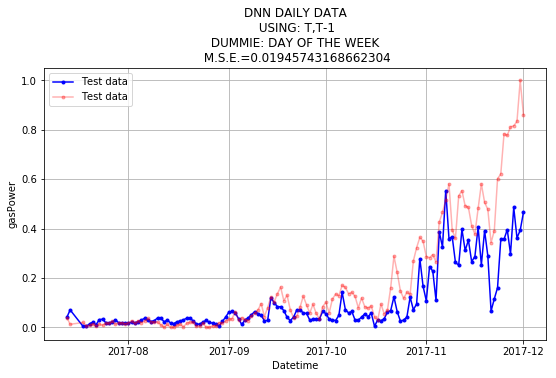

In [22]:
from sklearn.metrics import mean_squared_error
X1_datetime=df_day.index[len(X_train):]
y_test = (y_test-min(y_test))/(max(y_test)-min(y_test))

plt.figure(figsize=(9,5))

plt.title('DNN DAILY DATA\n USING: T,T-1\n DUMMIE: DAY OF THE WEEK \n M.S.E.='+str(mean_squared_error(y_test,y_pred)))
plt.grid(True)
plt.plot(X1_datetime,y_pred,'.-',color='b',label='Test data')
plt.xlabel('Datetime')
plt.ylabel('gasPower')
plt.plot(X1_datetime,y_test,'.-',color='r',label='Test data',alpha=0.3)


plt.legend()
#plt.savefig('dnn1.png', dpi=100)
plt.show()

